# Picnic Hackathon 🥇✅💯
 **When great customer support meets data**


## Why the challenge?
One of our core beliefs is to offer our customers the best support possible, by allowing them, for example, to send in pictures of defect products they wish to be reimbursed for. But processing these pictures is very time-consuming as it is all done manually.

## What is the challenge?
The challenge we propose is the following: As a first step in helping customer support, come up with a way of labeling every picture that comes in according to the product that is in the picture. To keep with the Picnic spirit, we encourage to be as innovative and creative with your solutions as possible.

## Dataset
To that end, we offer the following [dataset](https://github.com/Younes-Charfaoui/Picnic-Hackathon/blob/master/images/picnic_logo.png) of pictures of defect items.

## Setting & Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from keras.models import Sequential
from keras.layers import Dropout,Conv2D, MaxPooling2D, Activation, Dense, Flatten
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
import glob
import os
import cv2

Using TensorFlow backend.


In [3]:

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_to_folder = 'gdrive/My Drive/Dataset/The Picnic Hackathon 2019/'

In [0]:
df = pd.read_csv(path_to_folder + "train.tsv",  sep='\t')

In [0]:
datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [0]:
test = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = datagen.flow_from_dataframe(dataframe=df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32,
                                              subset = 'training')

valid_generator = datagen.flow_from_dataframe(dataframe=df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32,
                                              subset = 'validation')


Found 5804 images belonging to 25 classes.
Found 1451 images belonging to 25 classes.


In [0]:
step_epochs = train_generator.n // train_generator.batch_size

step_validation = valid_generator.n // valid_generator.batch_size

In [10]:
test_generator = datagen.flow_from_directory(directory= path_to_folder +  "test/",
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32)

Found 0 images belonging to 0 classes.


In [0]:
labels = train_generator.class_indices
labels = {v: k for k, v in labels.items()}

In [10]:
print(labels)

{0: 'Asparagus, string beans & brussels sprouts', 1: 'Bananas, apples & pears', 2: 'Bell peppers, zucchinis & eggplants', 3: 'Berries & cherries', 4: 'Broccoli, cauliflowers, carrots & radish', 5: 'Cheese', 6: 'Citrus fruits', 7: 'Cucumber, tomatoes & avocados', 8: 'Eggs', 9: 'Fish', 10: 'Fresh bread', 11: 'Fresh herbs', 12: 'Kiwis, grapes & mango', 13: 'Lunch & Deli Meats', 14: 'Milk', 15: 'Minced meat & meatballs', 16: 'Nectarines, peaches & apricots', 17: 'Onions, leek, garlic & beets', 18: 'Pineapples, melons & passion fruit', 19: 'Pork, beef & lamb', 20: 'Potatoes', 21: 'Poultry', 22: 'Pre-baked breads', 23: 'Pudding, yogurt & quark', 24: 'Salad & cress'}


In [0]:
"""X_list, y_list = [], []
size = train_generator.n//train_generator.batch_size
print(size)
for i in range(train_generator.n//train_generator.batch_size):
  print(i)
  X, y = train_generator.next()
  X_list.append(X)
  y_list.append(y)"""
  

In [11]:
X, y = train_generator.next()

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
# X_test, y_test = valid_generator.next()

In [0]:
"""from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, = train_test_split(X, y, shuffle = True, test_size = 0.3)"""

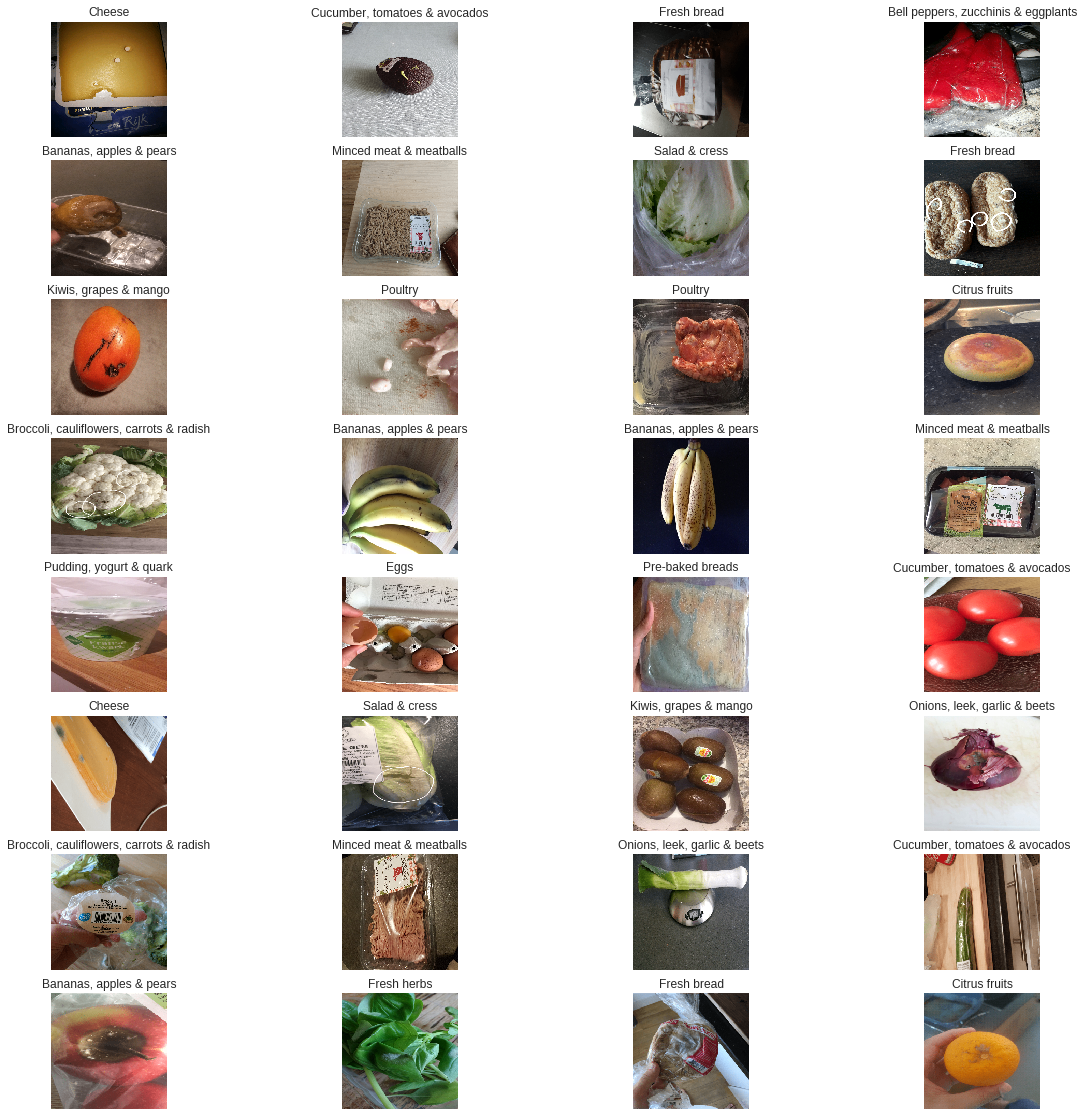

In [12]:
# Dsiplaying some images
fig = plt.figure(figsize = (20,20))
for i in range(32):
  ax = fig.add_subplot(8, 4, i+1, xticks = [], yticks = [])
  ax.imshow(X[i])
  ax.set_title(labels[np.argmax(y[i])])

## Building & Testing Model

In [0]:
# helper functions 
def train_model(model, epochs, name = "model", generator = True):
  early_stopping = EarlyStopping(patience=9)
  checkpointer = ModelCheckpoint(name + 'best.h5', verbose=1, save_best_only=True)
  if generator:
    history = model.fit_generator(train_generator, epochs= epochs, 
                                  steps_per_epoch= step_epochs, 
                                  validation_steps=step_validation, 
                                  validation_data = valid_generator, 
                                  callbacks=[early_stopping, checkpointer])
  else:
    history = model.fit(x_train, y_train, epochs= epochs, batch_size = 32, 
                        validation_data= (x_test,y_test),
                       callbacks=[early_stopping, checkpointer])
  model.load_weights(name + 'best.h5')
  score = model.evaluate_generator(valid_generator, steps = step_validation)
  print('Accuracy of {}%'.format(score[1]*100))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Losses')
  plt.legend()
  plt.show()
  plt.plot(history.history['acc'], label='Training acc')
  plt.plot(history.history['val_acc'], label='Validation acc')
  plt.legend()
  plt.title('Accuracies')
  plt.show()

In [0]:
# Building simple model
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))
model.summary()

In [0]:
train_model(model, 10)

In [0]:
# Building some complex models
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', input_shape = (224,224,3), activation = 'relu'))
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(16, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(32, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation = 'softmax'))
model.summary()

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop' , metrics = ['accuracy'])

In [0]:
train_model(model, 5)

## Transfer Learning

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 

## Summary of Pre-Trained Model

In [0]:
# helper function to visualize models 
def show_model(name, weight = 'imagenet', pool = 'avg'):
  
  if name == 'resnet':
    model = ResNet50(include_top=False, weights= weight, pooling= pool)
  if name == 'xception':
    model = Xception(include_top=False, weights= weight, pooling= pool)
    
    for layer in model.layers:
      
      print("{}, {}".format(layer, layer.trainable))
  elif name == 'mobilenet':
    model = MobileNetV2(include_top=False, weights= weight, pooling= pool)
    for layer in model.layers:
      
      print("{}, {}".format(layer, layer.trainable))
  elif name == 'nasnet':
    model = NASNetMobile(include_top=False, weights= weight, pooling= pool)
  elif name == 'nasnet_large':
    model = NASNetLarge(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  elif name == 'densenet121':
    model = DenseNet121(include_top=False, weights= weight, pooling= pool)
  elif name == 'densenet169':
    model = DenseNet169(include_top=False, weights= weight, pooling= pool)
  elif name == 'densenet201':
    model = DenseNet201(include_top=False, weights= weight, pooling= pool)
  elif name == 'vgg16':
    model = VGG16(include_top=False, weights= weight, pooling= pool)
  elif name == 'vgg19':
    model = VGG19(include_top=False, weights= weight, pooling= pool)
  elif name == 'inception_v3':
    model = InceptionV3(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  elif name == 'inception_resnet_v3':
    model = InceptionResNetV2(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool)
  
  
  model.summary()

In [0]:
show_model('mobilenet')

## Training of Model

In [0]:
# helper function to creat models 
def make_model(name, weight = 'imagenet', pool = 'avg'):
  model = Sequential()
  if name == 'resnet':
    resnet = ResNet50(include_top=False, weights= weight, pooling= pool)
    for layer in resnet.layers:
        layer.trainable=False
    model.add(resnet)
  if name == 'xception':
    xception = Xception(include_top=False, weights= weight, pooling= pool)
    for layer in xception.layers[:-9]:
        layer.trainable = False
    model.add(xception)
  elif name == 'mobilenet':
    model.add(MobileNetV2(include_top=False, weights= weight, pooling= pool))
  elif name == 'nasnet':
    model.add(NASNetMobile(include_top=False, weights= weight, pooling= pool))
  elif name == 'densenet121':
    model.add(DenseNet121(include_top=False, weights= weight, pooling= pool))
  elif name == 'densenet169':
    model.add(DenseNet201(include_top=False, weights= weight, pooling= pool))    
  elif name == 'vgg16':
    vgg_conv = VGG16(include_top=False, weights= weight, pooling= pool)
    for layer in vgg_conv.layers[:-4]:
      layer.trainable = False
    model.add(vgg_conv)
  elif name == 'vgg19':
    model.add(VGG19(include_top=False, weights= weight, pooling= pool))
  elif name == 'inception_v3':
    model.add(InceptionV3(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool))
  elif name == 'inception_resnet_v3':
    model.add(InceptionResNetV2(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool))
  elif name == 'nasnet_large':
    model.add(NASNetLarge(include_top = False, weights= weight, input_shape=(224,224,3), pooling = pool))
  
  """if pool is None:
    model.add(Flatten())"""
  
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(25, activation = 'softmax'))
  model.summary()
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
  
  return model   

In [0]:
models = ['resnet' , 'mobilenet', 'nasnet', 'densenet121', 'densenet169', 'densenet201', 'vgg16', 'vgg19', 'inception_resnet_v3', 'inception_v3', 'nasnet_large', 'xception']

In [35]:
model = make_model('densenet169', pool = 'max')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1967104   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 25)                12825     
Total params: 20,826,713
Trainable params: 20,597,657
Non-trainable params: 229,056
__________________________________________________________

In [0]:
train_model(model , 5)

In [0]:
model = make_model('resnet')
train_model(model , 5)

In [0]:
model = make_model('nasnet')
train_model(model , 50)

In [0]:
model = make_model('vgg16')

In [0]:
train_model(model, 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 25)                12825     
Total params: 23,497,281
Trainable params: 7,386,649
Non-trainable params: 16,110,632
________________________________________________________

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


181/181 [==============================] - 353s 2s/step - loss: 2.2522 - acc: 0.3657 - val_loss: 1.5503 - val_acc: 0.5927

Epoch 00001: val_loss improved from inf to 1.55030, saving model to modelbest.h5
Epoch 2/5
181/181 [==============================] - 240s 1s/step - loss: 1.2965 - acc: 0.6329 - val_loss: 1.3589 - val_acc: 0.6519

Epoch 00002: val_loss improved from 1.55030 to 1.35889, saving model to modelbest.h5
Epoch 3/5
181/181 [==============================] - 242s 1s/step - loss: 0.8464 - acc: 0.7536 - val_loss: 1.6753 - val_acc: 0.6512

Epoch 00003: val_loss did not improve from 1.35889
Epoch 4/5
181/181 [==============================] - 242s 1s/step - loss: 0.6537 - acc: 0.8144 - val_loss: 1.3667 - val_acc: 0.6857

Epoch 00004: val_loss did not improve from 1.35889
Epoch 5/5
181/181 [==============================] - 245s 1s/step - loss: 0.5026 - acc: 0.8572 - val_loss: 1.5663 - val_acc: 0.6899

Epoch 00005: val_loss did not improve from 1.35889
Accuracy of 66.94855531224

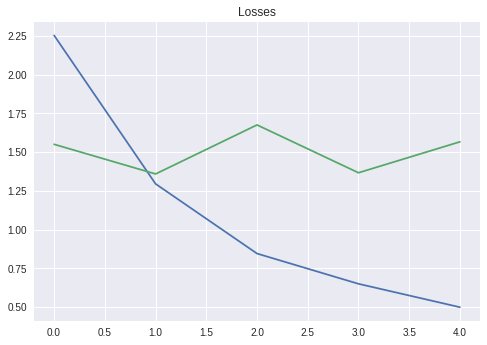

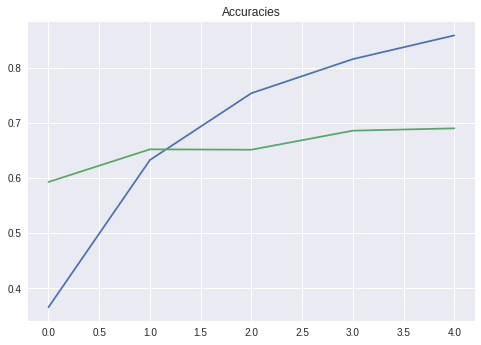

In [37]:
model = make_model('xception', pool = 'max')
train_model(model , 5)

In [0]:
model = make_model('mobilenet')
train_model(model , 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 25)                12825     
Total params: 8,624,729
Trainable params: 8,541,081
Non-trainable params: 83,648
_____________________________________________________________

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


181/181 [==============================] - 513s 3s/step - loss: 2.4150 - acc: 0.3267 - val_loss: 2.7297 - val_acc: 0.3270

Epoch 00001: val_loss improved from inf to 2.72967, saving model to modelbest.h5
Epoch 2/5
181/181 [==============================] - 289s 2s/step - loss: 1.9028 - acc: 0.4575 - val_loss: 2.3646 - val_acc: 0.4116

Epoch 00002: val_loss improved from 2.72967 to 2.36462, saving model to modelbest.h5
Epoch 3/5
181/181 [==============================] - 295s 2s/step - loss: 1.6215 - acc: 0.5343 - val_loss: 1.6769 - val_acc: 0.5285

Epoch 00003: val_loss improved from 2.36462 to 1.67687, saving model to modelbest.h5
Epoch 4/5
181/181 [==============================] - 295s 2s/step - loss: 1.5299 - acc: 0.5610 - val_loss: 1.7566 - val_acc: 0.5194

Epoch 00004: val_loss did not improve from 1.67687
Epoch 5/5
181/181 [==============================] - 298s 2s/step - loss: 1.3490 - acc: 0.6134 - val_loss: 2.4811 - val_acc: 0.4031

Epoch 00005: val_loss did not improve from 

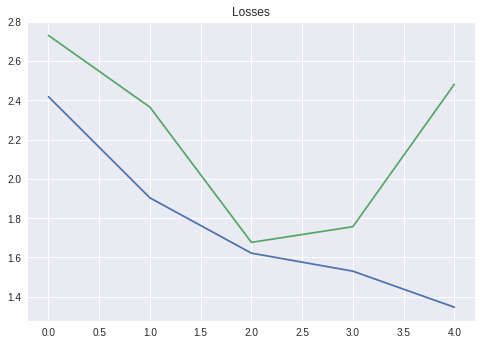

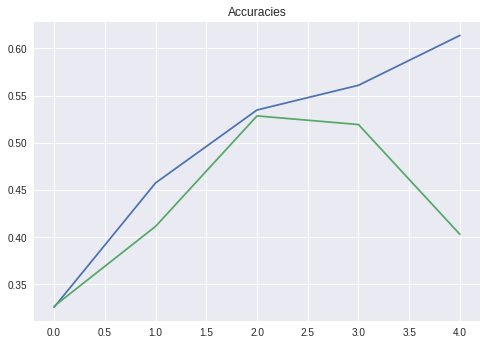

In [66]:
model = make_model('densenet121')


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


181/181 [==============================] - 307s 2s/step - loss: 1.1301 - acc: 0.6770 - val_loss: 1.7113 - val_acc: 0.5638

Epoch 00001: val_loss improved from inf to 1.71127, saving model to modelbest.h5
Epoch 2/10
181/181 [==============================] - 290s 2s/step - loss: 0.9911 - acc: 0.7160 - val_loss: 2.1367 - val_acc: 0.5095

Epoch 00002: val_loss did not improve from 1.71127
Epoch 3/10
181/181 [==============================] - 300s 2s/step - loss: 0.9382 - acc: 0.7296 - val_loss: 1.8590 - val_acc: 0.5504

Epoch 00003: val_loss did not improve from 1.71127
Epoch 4/10
181/181 [==============================] - 294s 2s/step - loss: 0.9465 - acc: 0.7234 - val_loss: 1.6321 - val_acc: 0.5645

Epoch 00004: val_loss improved from 1.71127 to 1.63208, saving model to modelbest.h5
Epoch 5/10
181/181 [==============================] - 299s 2s/step - loss: 0.8353 - acc: 0.7592 - val_loss: 2.0939 - val_acc: 0.4778

Epoch 00005: val_loss did not improve from 1.63208
Epoch 6/10
181/181 [==

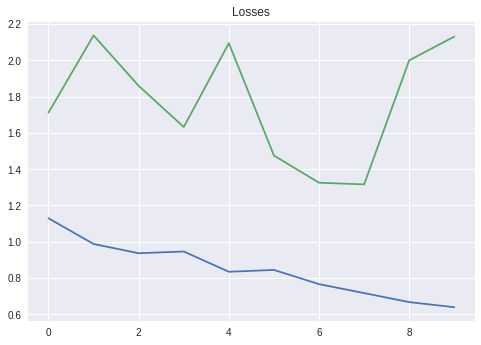

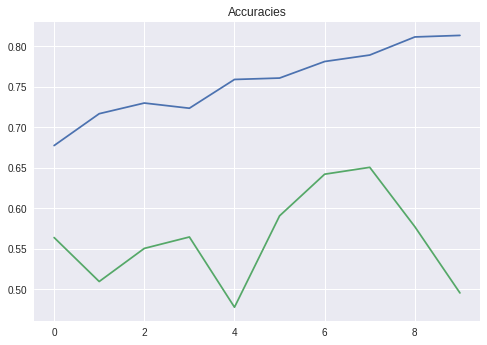

In [68]:
train_model(model , 10)

In [0]:
model.save_weights("densenet.model.h5")

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("densnetmodel.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
score = model.evaluate_generator(valid_generator, steps = step_validation)

## Exporting Results

In [0]:
files = glob.glob(path_to_folder + 'test/*')

In [0]:
results = []
i = 0
for file in files:
    print(i)
    i+=1
    img = cv2.imread(file,1)
    img = cv2.resize(img, (224, 224)) 
    img = img/255
    result = model.predict([[img]])
    label = labels[np.argmax(result)]
    filename = os.path.basename(file)
    results.append([filename, label])

In [24]:
results[0]

['7552.png', 'Bell peppers, zucchinis & eggplants']

In [25]:
headers = ['file', 'label']
df = pd.DataFrame(results, columns=headers)
df.head()

,file,label
0,7552.png,"Bell peppers, zucchinis & eggplants"
1,7492.png,"Pudding, yogurt & quark"
2,7467.png,Citrus fruits
3,7774.png,"Pork, beef & lamb"
4,7469.png,"Pudding, yogurt & quark"


In [0]:
df = df.sort_values(['file'])

In [27]:
df.head()

,file,label
503,7263.jpeg,"Cucumber, tomatoes & avocados"
520,7264.jpeg,"Cucumber, tomatoes & avocados"
571,7265.jpeg,"Broccoli, cauliflowers, carrots & radish"
332,7266.png,Berries & cherries
513,7267.jpeg,Potatoes


In [0]:
df.to_csv("submission.tsv", sep ='\t', index = False)

In [0]:
model.save_weights(path_to_folder + 'pinic_xception.h5')